In [1]:
%run init_notebook.py
from settings import DATA_DIR

In [2]:
import pandas as pd
import numpy as np

import eurostat

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

from scipy.stats import normaltest

import os

In [3]:
from io import StringIO
import sys

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout

def write_to_txt(output: str, file_name):
    f = open(os.path.join(GRAPHS_DIR, file_name), 'w+')
    f.write(output)
    f.close()
    pass

In [3]:
from src.utils import get_samp

In [4]:
def _sample(array, n_samples):
    """Little utility function, sample n_samples with replacement"""
    idx = np.random.choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]

In [5]:
def get_VAR_arr(data: np.array, n_lags):
    return np.concatenate([data[i:len(data)-(n_lags-i)] for i in range(1, n_lags+1)], axis=1)

In [12]:
# load data

In [7]:
cpi = pd.read_csv(os.path.join(DATA_DIR, 'cpi.csv'))

In [8]:
cpi = cpi.rename(columns={'Unnamed: 0': 'date'})
cpi['date'] = cpi['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
cpi.set_index('date', inplace=True)

In [12]:
# train test split

In [13]:
t = cpi.index.dropna().date
cpi['t'] = np.array((t - t.min()) / (t.max() - t.min()))

_train = cpi.dropna().loc[datetime(2010,1,1):datetime(2020,3,1)].copy()
_test = cpi.dropna().loc[datetime(2020,3,1):].copy()

t, y = _train['t'].values.astype(float), _train['pi_de'].values.astype(float)
t_test, y_test = _test['t'].values.astype(float), _test['pi_de'].values.astype(float)

In [14]:
# model linear

In [21]:
_train.pi_de.mean()

0.0011100498628152293

In [22]:
with pm.Model() as linear:
    alpha = pm.Normal("alpha", mu=0, sigma=0.1)
    beta = pm.Normal("beta", mu=0, sigma=0.25)
    sigma = pm.HalfNormal("sigma", sigma=0.05)
    
    trend = pm.Deterministic("trend", alpha + t * beta)

    pm.Normal("likelihood", mu=trend, sigma=sigma, observed=y)

    linear_prior_predictive = pm.sample_prior_predictive(samples=100)

Sampling: [alpha, beta, likelihood, sigma]


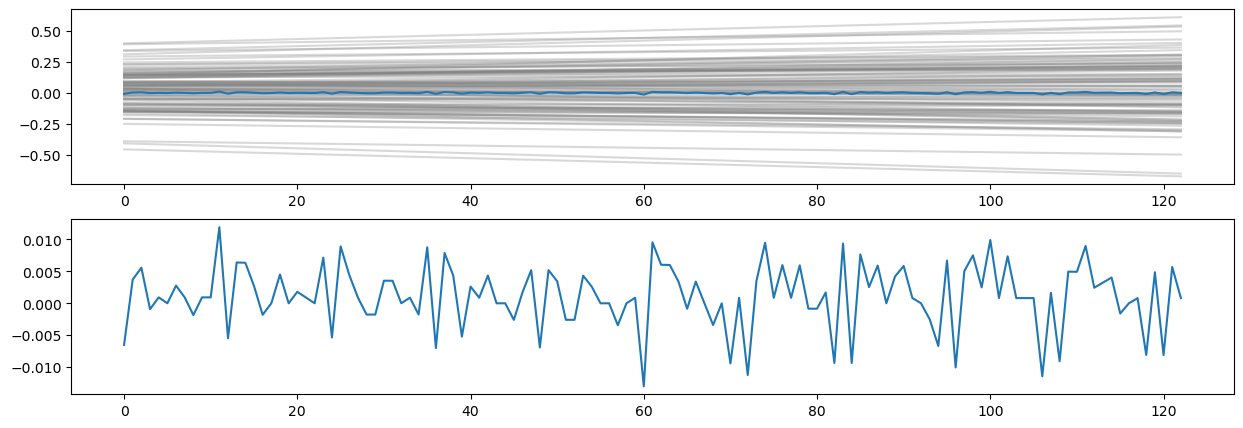

In [25]:
samp = linear_prior_predictive.prior

fig, ax = plt.subplots(2,1, figsize=(15,5))
ax[0].plot(
    samp['alpha'].values + t.reshape(len(t),1) @ samp['beta'].values + samp['sigma'].values,
    alpha=.3, color='grey'
)
ax[0].plot(y)
ax[1].plot(y);

In [26]:
with linear:
    linear_posterior_sample = pm.sample(return_inferencedata=True)
    linear_posterior_predictive = pm.sample_posterior_predictive(linear_posterior_sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
Sampling: [likelihood]


''

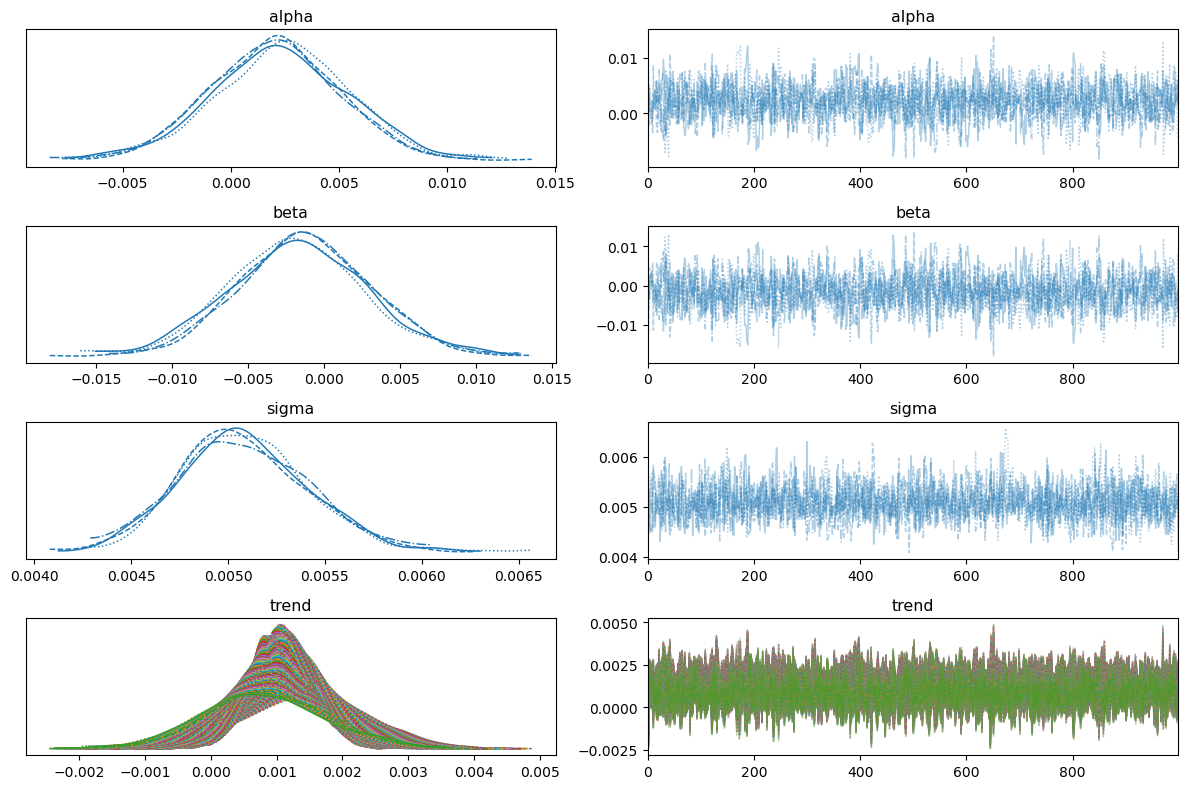

In [29]:
az.plot_trace(linear_posterior_sample)
plt.tight_layout();

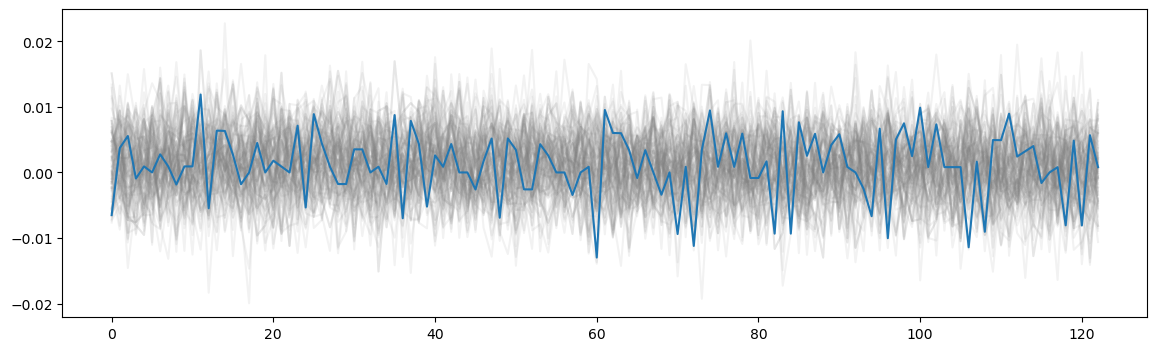

In [30]:
fig = plt.figure(figsize=(14,4))
plt.plot(
    linear_posterior_predictive.posterior_predictive['likelihood'][0, get_samp(1_000, 100), :].values.T,
    alpha=.1, 
    color='grey'
)
plt.plot(y);

In [31]:
# linear and AR

In [38]:
n_lags = 1
with pm.Model() as ar_lin:
    alpha = pm.Normal("alpha", mu=0, sigma=0.01)
    beta = pm.Normal("beta", mu=0, sigma=0.01)
    
    rho = pm.Normal("rho", mu=0, sigma=.05, shape=n_lags)
    sigma = pm.HalfNormal("sigma", sigma=0.05)
        
    trend = pm.Deterministic("trend", alpha + t[:-n_lags] * beta)
    mu = pm.Deterministic("mu", trend + y[n_lags:, None] @ rho)

    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y[:-n_lags])

    ar_lin_prior_pred = pm.sample_prior_predictive(samples=100)

Sampling: [alpha, beta, likelihood, rho, sigma]


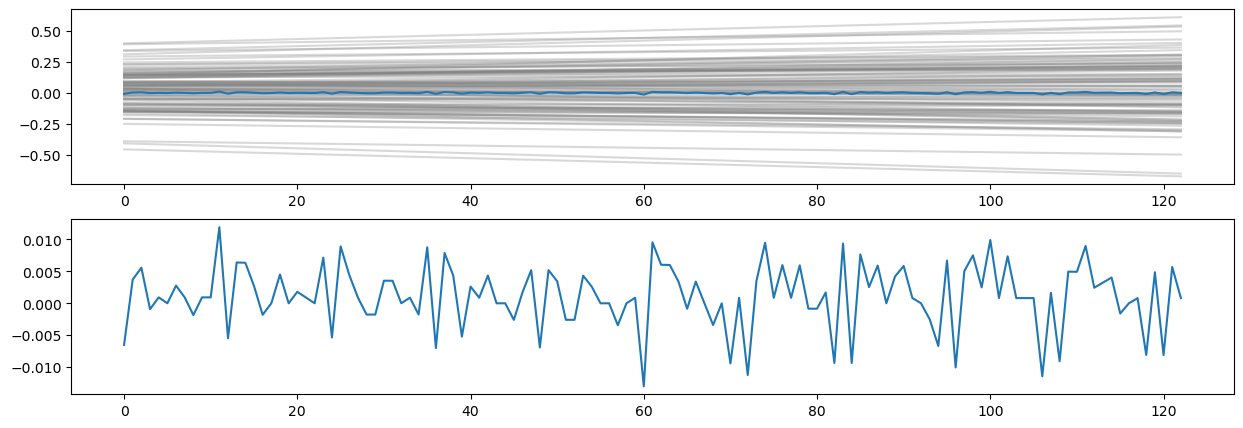

In [40]:
samp = linear_prior_predictive.prior

fig, ax = plt.subplots(2,1, figsize=(15,5))
ax[0].plot(
    samp['alpha'].values + t.reshape(len(t),1) @ samp['beta'].values + samp['sigma'].values,
    alpha=.3, color='grey'
)
ax[0].plot(y)
ax[1].plot(y);

In [44]:
with ar_lin:
    ar_lin_post = pm.sample(return_inferencedata=True)
    ar_lin_post_pred = pm.sample_posterior_predictive(ar_lin_post)

Sampling: [likelihood]


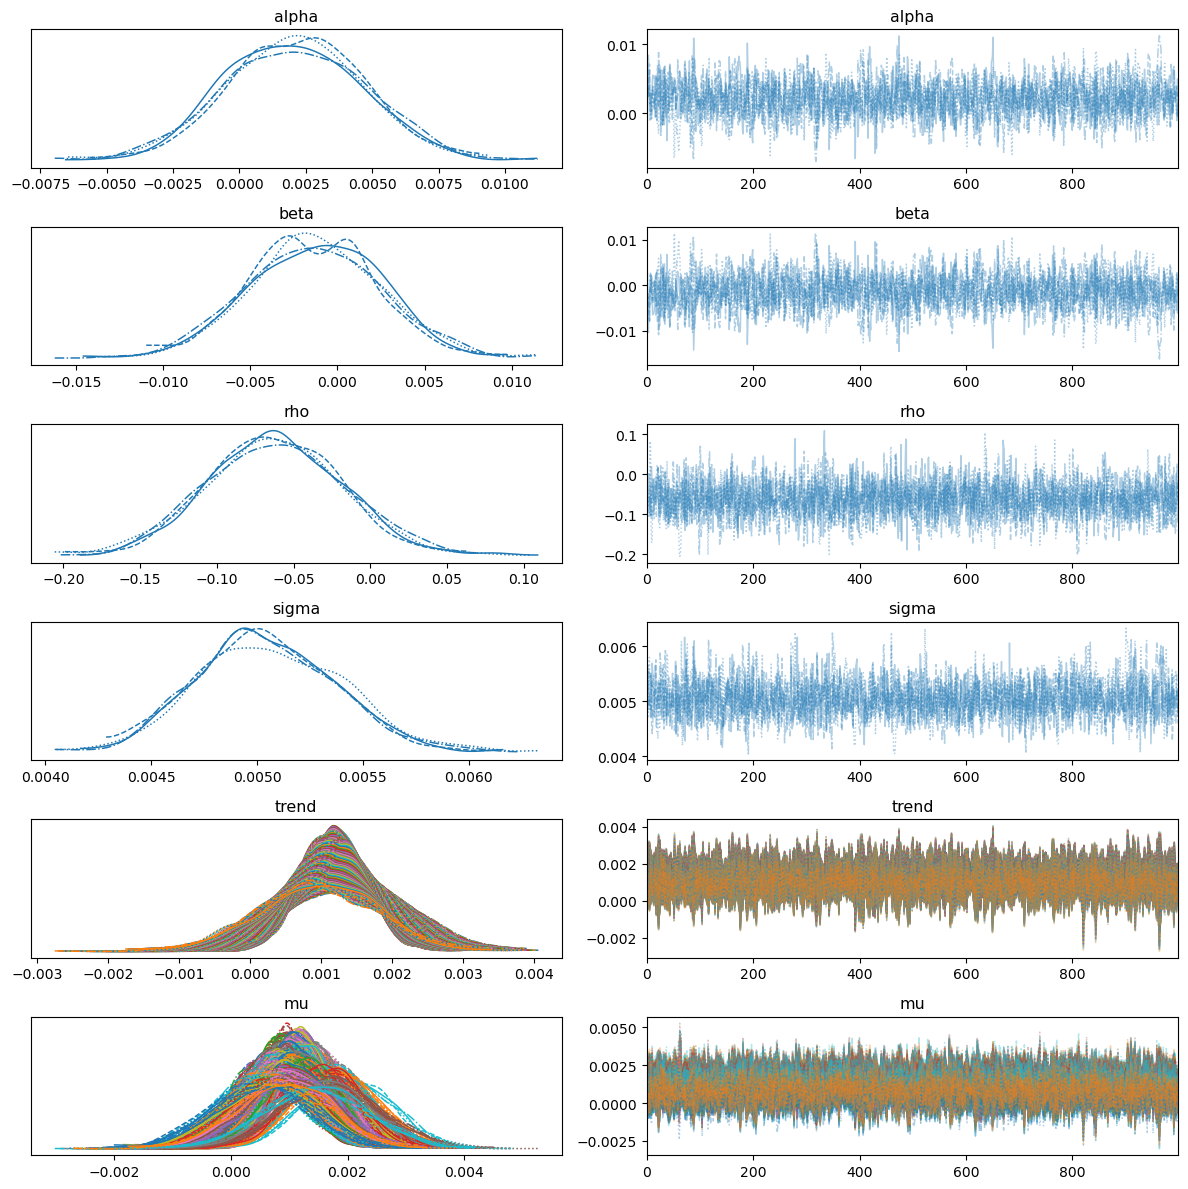

In [45]:
az.plot_trace(ar_lin_post)
plt.tight_layout();

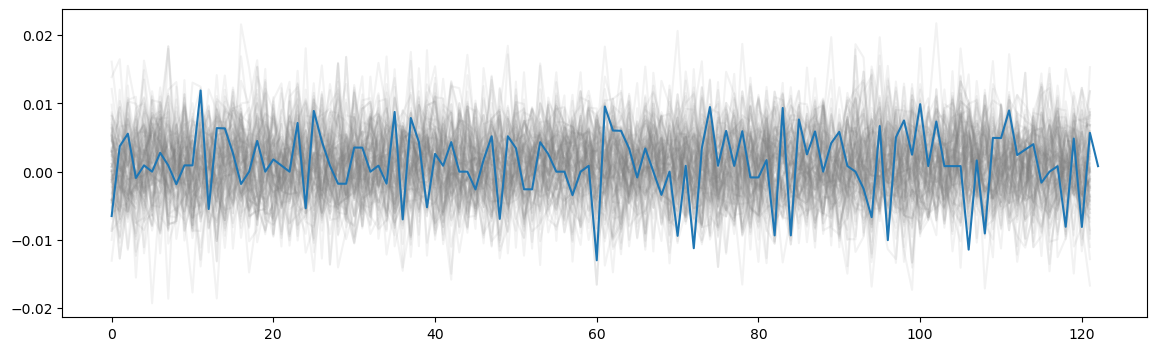

In [48]:
fig = plt.figure(figsize=(14,4))
plt.plot(
    ar_lin_post_pred.posterior_predictive['likelihood'][0, get_samp(1_000, 100), :].values.T,
    alpha=.1, 
    color='grey'
)
plt.plot(y);

In [49]:
# seasonal

In [50]:
n_order = 10
periods = _train.reset_index()['date'].dropna().dt.dayofyear / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

periods = _test.reset_index()['date'].dropna().dt.dayofyear / 365.25
fourier_features_test = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)
# fourier_features

In [54]:
n_lags = 1
coords = {"fourier_features": np.arange(2 * n_order)}

with pm.Model(check_bounds=False, coords=coords) as ar_lin_seas:
    alpha = pm.Normal("alpha", mu=0, sigma=0.1)
    beta = pm.Normal("beta", mu=0, sigma=0.1)
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    rho = pm.Normal("rho", mu=0, sigma=.5, shape=n_lags)
    beta_f = pm.Normal("beta_f", mu=0, sigma=10, dims="fourier_features")
    
    seasonality = pm.Deterministic("seasonality", pm.math.dot(beta_f, fourier_features.iloc[:-n_lags].to_numpy().T))
    
    trend = pm.Deterministic("trend", alpha + t[:-n_lags] * beta)
    ar_p = pm.Deterministic("ar", y[n_lags:, None] @ rho)
    mu = trend * (1 + seasonality) + ar_p
        
    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y[:-n_lags])

    ar_lin_seas_prior = pm.sample_prior_predictive()

Sampling: [alpha, beta, beta_f, likelihood, rho, sigma]


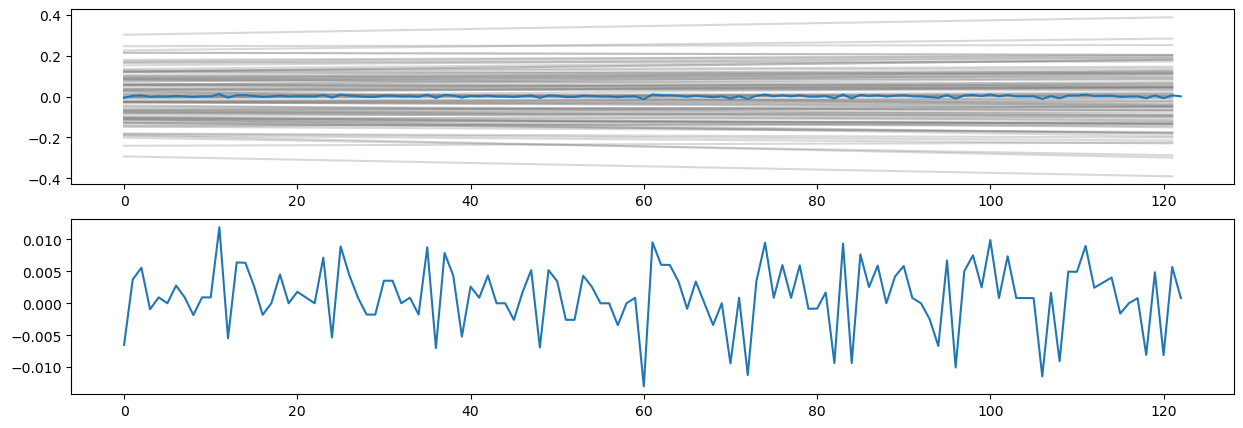

In [55]:
fig, ax = plt.subplots(2,1, figsize=(15,5))
ax[0].plot(
    _sample(ar_lin_seas_prior.prior['trend'][0], 100).T,
    alpha=.3, color='grey'
)
ax[0].plot(y)
ax[1].plot(y);

In [57]:
with ar_lin_seas:
    ar_lin_seas_post = pm.sample(return_inferencedata=True)
    ar_lin_seas_post_pred = pm.sample_posterior_predictive(ar_lin_seas_post)

Sampling: [likelihood]


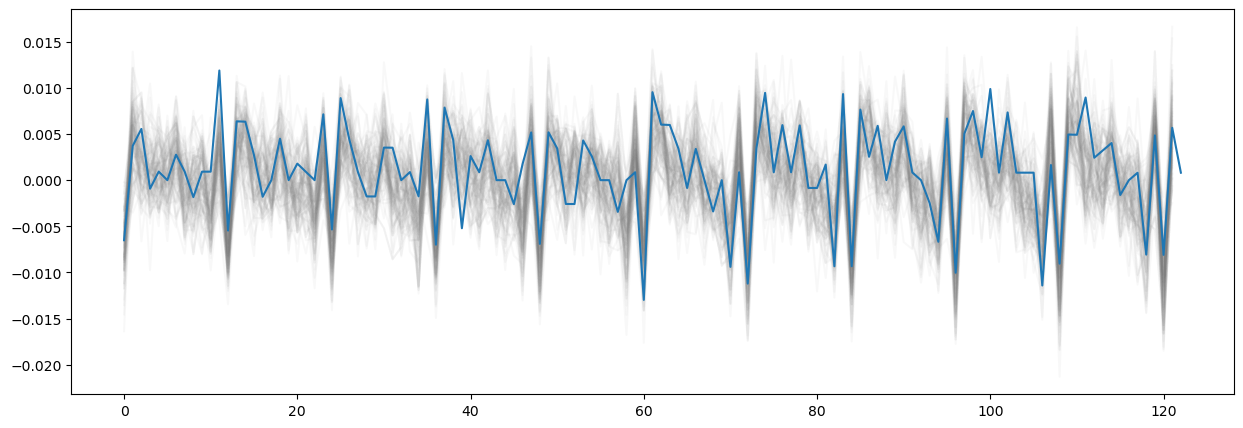

In [59]:
fig = plt.figure(figsize=(15,5))
plt.plot(
    _sample(ar_lin_seas_post_pred.posterior_predictive['likelihood'][0], 100).T, 
    alpha=.05, 
    color='grey'
)
plt.plot(y);

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_miscell\Lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


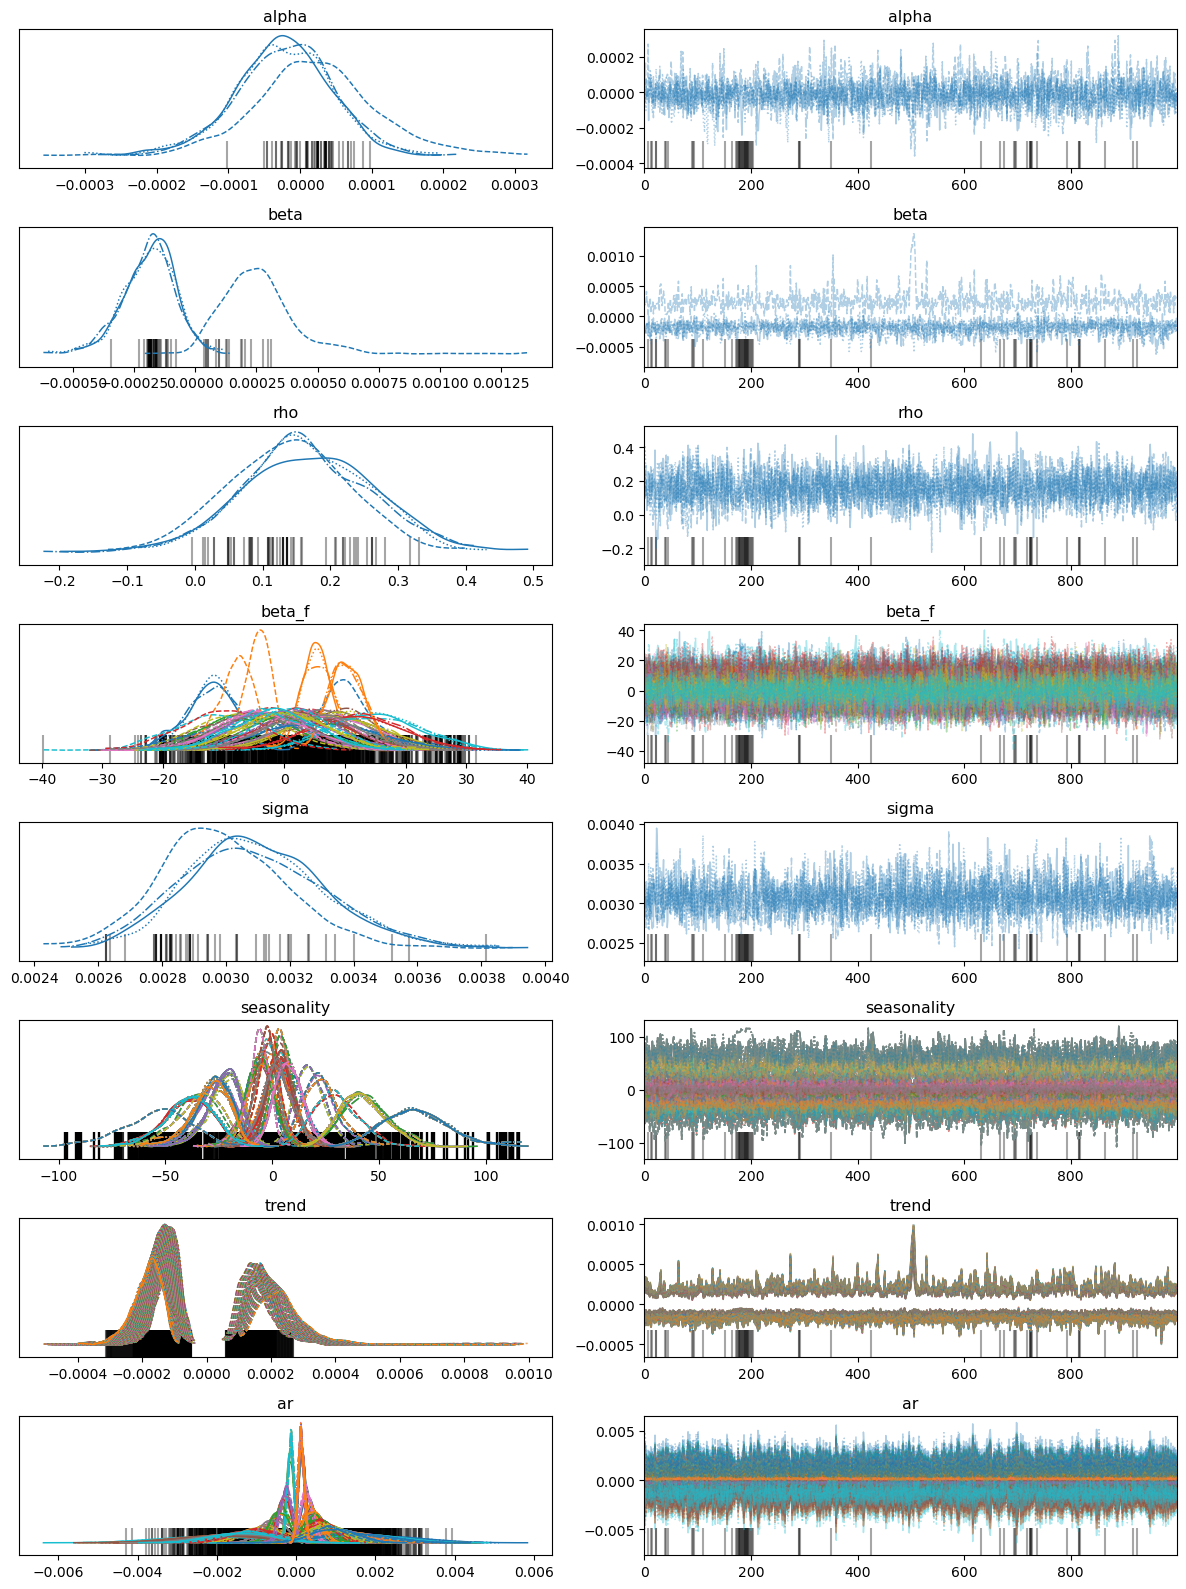

In [61]:
az.plot_trace(ar_lin_seas_post)
plt.tight_layout();

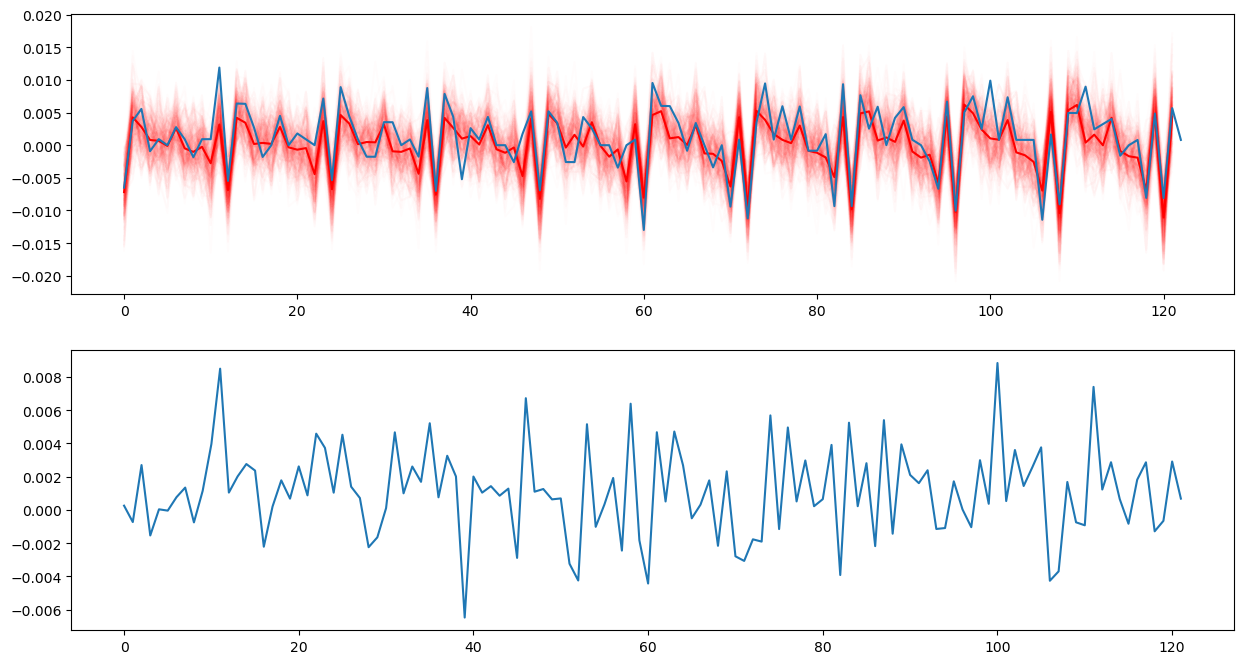

In [63]:
samp = ar_lin_seas_post_pred.posterior_predictive['likelihood']
resid = (y[:-n_lags] - samp[0, get_samp(1_000, 200), :].T.median(axis=1)).values

fig, ax = plt.subplots(2, 1, figsize=(15, 8))
ax[0].plot(
    samp[0, get_samp(1_000, 300), :].T,
    alpha=.01, 
    color='red'
)
ax[0].plot(
    samp[0, get_samp(1_000, 200), :].T.median(axis=1),
    color='red',
)
ax[0].plot(y)
ax[1].plot(resid);

In [64]:
# forecast

In [66]:
samp = ar_lin_seas_post.posterior

In [69]:
trend = np.expand_dims(samp['alpha'][:, get_samp(1_000, 100)].values.ravel(), axis=0) + \
            t_test.reshape(len(t_test), 1) @ np.expand_dims(samp['beta'][:, get_samp(1_000, 100)].values.ravel(), axis=0)
season = (samp['beta_f'].values[:, get_samp(1_000, 100)].reshape(400, 20) @ fourier_features_test.to_numpy().T).T
forecast = trend * (1 + season)

resid_test = y_test - forecast.mean(1)

In [73]:
# nice plot

In [76]:
samp = ar_lin_post_pred.posterior_predictive['likelihood']

data_mod = samp[:, get_samp(1_000, 100), :].values.reshape(400, len(y)-n_lags)
data_forecast = np.concatenate([np.zeros((400, len(y)-n_lags)) * np.nan, forecast.T], axis=1)

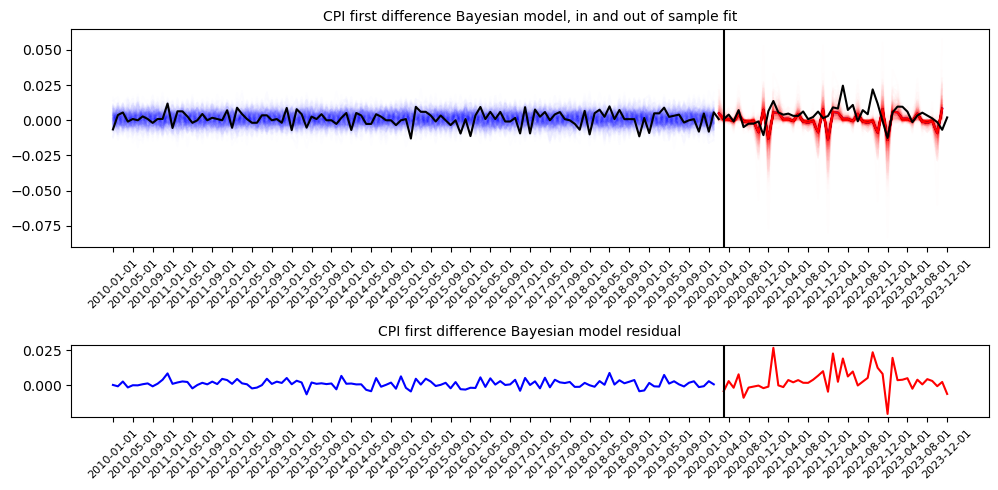

In [116]:
fig, ax = plt.subplots(2,1, figsize=(10,5), gridspec_kw={'height_ratios': [3, 1]})
ax[0].plot(data_mod.T, alpha=.0075, color='blue')
ax[0].plot(data_forecast.T.mean(axis=1), color='blue')

ax[0].plot(data_forecast.T, alpha=.0075, color='red')
ax[0].plot(data_forecast.T.mean(axis=1), color='red')

ax[0].plot(y, color='black')
ax[0].plot(np.concatenate([np.zeros(len(y)) * np.nan, y_test]), color='black')

ax[1].plot(resid, color='blue')
ax[1].plot(np.concatenate([np.zeros(len(y)) * np.nan, resid_test]), color='red')

ax[1].plot()

ax[0].axvline(len(y), color='black')
ax[1].axvline(len(y), color='black')

ax[0].set_title('CPI first difference Bayesian model, in and out of sample fit', size=10)
ax[1].set_title('CPI first difference Bayesian model residual', size=10)

idx = [*chain(list(_train.index), list(_test.index))]

ax[0].set_xticks([*range(0, len(idx))][0::4])
ax[0].set_xticklabels([i.date() for i in idx][0::4], rotation=45, size=8)

ax[1].set_xticks([*range(0, len(idx))][0::4])
ax[1].set_xticklabels([i.date() for i in idx][0::4], rotation=45, size=8)


plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph1.png'));

In [83]:
import scipy

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_miscell\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_miscell\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_miscell\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_miscell\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option i

''

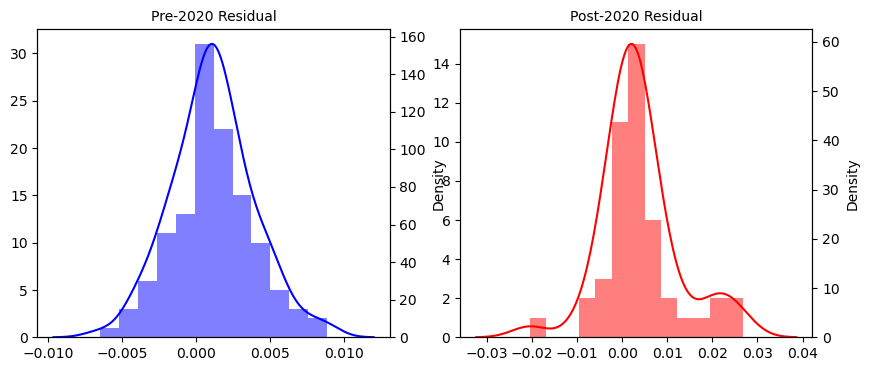

In [117]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].hist(resid, bins='fd', density=False, label='pre-2020', alpha=.5, color='blue', )
sns.kdeplot(resid, ax=ax[0].twinx(), color='blue')
ax[1].hist(resid_test, bins='fd', density=False, label='pos-2020', alpha=.5, color='red')
sns.kdeplot(resid_test, ax=ax[1].twinx(), color='red')

ax[0].set_title(f'Pre-2020 Residual', size=10)
ax[1].set_title(f'Post-2020 Residual', size=10)
# plt.tight_layout()

fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph2.png'))

;

In [97]:
# merge data

In [104]:
_train['is_train'] = np.zeros(len(_train)) + True
_test['is_train'] = np.zeros(len(_test)) + False

df = pd.concat([_train, _test], axis=0).copy()
df = df.iloc[:-1]
df['is_train'] = df.is_train.astype(bool)

df['pi_de_surprise'] = np.concatenate([resid, resid_test])

arr = np.concatenate(
    [
        ar_lin_seas_post_pred.posterior_predictive.likelihood.values[:, get_samp(1_000, 100)].mean(axis=(0,1)),
        forecast.mean(axis=1)
    ]
)

df['pi_de_estimate'] = arr
df.drop('t', axis=1, inplace=True)

In [105]:
# annual inflation

In [106]:
# get annual inflation
df = df.join(
    df[['pi_de', 'pi_de_estimate', 'pi_de_surprise']].rolling(12).apply(lambda x: np.prod(x + 1) - 1).add_suffix('_Y')
)

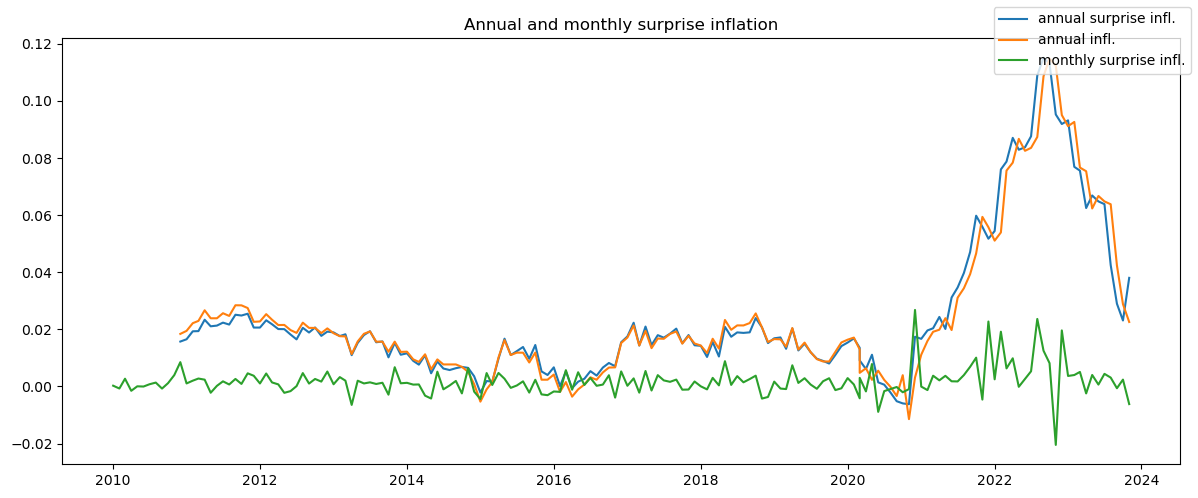

In [107]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.plot(df.pi_de_surprise_Y, label='annual surprise infl.')
ax.plot(df.pi_de_Y, label='annual infl.')
ax.plot(df.pi_de_surprise, label='monthly surprise infl.')
# ax.plot(df.pi_de_Y, label='realised infl.')

fig.legend()
ax.set_title('Annual and monthly surprise inflation')

plt.tight_layout()

fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_surp_infl.png'))

In [108]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [115]:
with Capturing() as output:
    print("Ljung Box test for residual autocorrelation: H0 data is indipendently distributed")
    print("\n2010-01-01 to 2020-03-01")
    print(acorr_ljungbox(df[~df.is_train].pi_de_surprise))
    
    print("\n2020-03-01 to 2023-09-01")
    print(acorr_ljungbox(df[~df.is_train].pi_de_surprise))
write_to_txt("\n".join(output), "infl_ljunbox.txt")

In [114]:
df.to_csv(os.path.join(DATA_DIR, 'de_inf_prepro.csv'))